# Mode fitting

Here we will make a simple hierarchical model that encodes some knowledge of quasi-equally spaced modes of oscillation into the prior.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

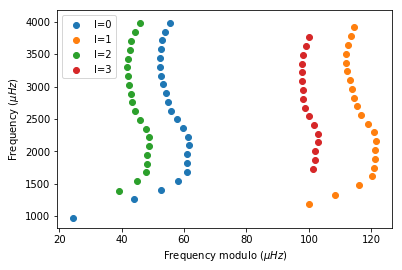

In [7]:
dnu_sol = 136  # book value of large freq separation for the sun

df = pd.read_table('broomhall2009.txt', delim_whitespace=True, names=('n', 'l', 'nu', 'nu_unc'))  #import data

lmodes = []
dnu_avg = []
f_mod = []

for i in range(4):
    lmodes.append(df[df.l == i])
    dnu_avg.append(np.median(np.diff(lmodes[i].nu)))
    f_mod.append(lmodes[i].nu % dnu_avg[i])
    label = "l="+str(i)
    plt.scatter(f_mod[i], lmodes[i].nu, label = label)
    
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

The lower departure from a straight line is due to the BCZ, so the lower frequencies are not useful in analysing the response from the HeII ionization zone. Frequencies below 1700 $\mu$Hz are omitted.

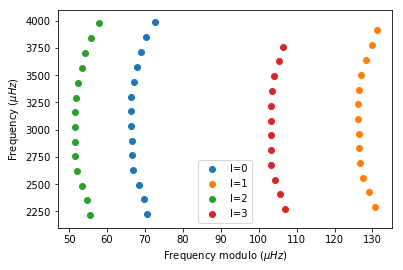

In [25]:
for i in range(4):
    lmodes[i] = lmodes[i].loc[lmodes[i].nu > 2200]
    lmodes[i] = lmodes[i].set_index(np.arange(0,len(lmodes[i]),1))

dnu_avg = []
f_mod = []
for i in range(4):
    dnu_avg.append(np.median(np.diff(lmodes[i].nu)))
    f_mod.append(lmodes[i].nu % dnu_avg[i])
    label = "l="+str(i)
    plt.scatter(f_mod[i], lmodes[i].nu, label = label)
    
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

To find a ballpark figure before defining priors, I will apply the model from Vrard:

$$\nu_{UP}(n,0)=\bigg(n+\epsilon+\frac{\alpha}{2}(n-n_{max})^2+\frac{\mathcal{A}\mathcal{G}}{2\pi}sin\bigg(\frac{2\pi(n-n_{max})}{\mathcal{G}}+\phi\bigg)\bigg)\langle\Delta\nu\rangle$$

In [26]:
def model(n, dnu, nmax, epsilon, k, A, w, tau, phi):
    freqs = (n + epsilon) * dnu + k * (nmax - n)**2 + A * np.exp(-n/tau) * np.sin(n * w + phi);
    return freqs

In [77]:
n = lmodes[0].n
dnu = dnu_avg[0]
numax = 2800
epsilon = 1.37
nmax = 22
k = 1.0
A = 0.003
w = 0.9
tau = 50
phi = 0
f = model(n, dnu, nmax, epsilon, k, A, w, tau, phi)

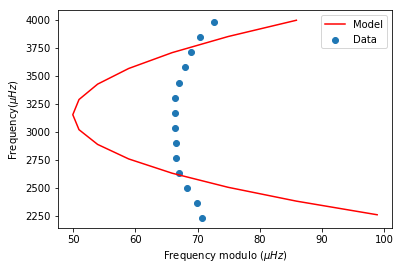

In [78]:
plt.scatter(f_mod[0], lmodes[0].nu, label = 'Data')
plt.plot(f % dnu_avg[0], f, label = 'Model', color = 'r')
plt.ylabel(r'Frequency($\mu Hz$)')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.legend()
#plt.xlim(0, 135.2)

In [94]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {
    real dnu;
    real epsilon;
    real<lower = 0> nmax;
    real k;
    real<lower = 0> A;
    real<lower = 0, upper = 1.5> w;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    real<lower = 0> tau;
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon) * dnu + k * (nmax - n[i])^2 + 
            A * exp(-n[i]/tau) * sin(n[i] * w + phi);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(1.5, 0.3);
    epsilon ~ uniform(0.0, 2.0);
    nmax ~ normal(22, 2);
    k ~ lognormal(log(0.1), 0.3);
    A ~ lognormal(log(1.0), 0.4);
    w ~ normal(1.0, 0.5);
    tau ~ normal(10, 10);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6c3c564c1761a0b0082e29e5c22382c NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpwc6wen74/stanfit4anon_model_f6c3c564c1761a0b0082e29e5c22382c_3640154815234154579.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [95]:
dnu = dnu_avg[0]
nmax_guess = 22
data = {'N': len(lmodes[0]), 'n': lmodes[0].n, 'freq': lmodes[0].nu, 'freq_err': lmodes[0].nu_unc, 
        'dnu_guess': dnu}
start = {'dnu': dnu, 'epsilon': 0, 'nmax': nmax_guess, 'k': 0.1, 'A': 1.0, 'w': 0.8, 'phi': 2.0, 'tau': 50}
nchains=4
fit = sm.sampling(data=data, iter=10000, chains=nchains, init=[start for n in range(nchains)])

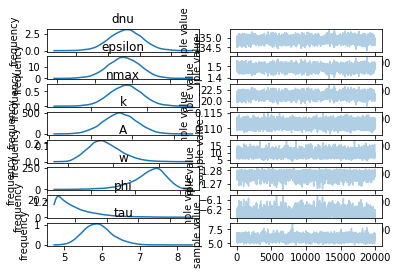

In [96]:
fit.plot()
plt.show()

In [97]:
print(fit)

Inference for Stan model: anon_model_f6c3c564c1761a0b0082e29e5c22382c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu     134.89  4.5e-3   0.13 134.64 134.81 134.89 134.98 135.15    812    1.0
epsilon   1.49  7.7e-4   0.02   1.45   1.47   1.49    1.5   1.53    812    1.0
nmax     21.23    0.02   0.58  20.08  20.84  21.24  21.62  22.37    812    1.0
k         0.11  1.6e-5 8.1e-4   0.11   0.11   0.11   0.11   0.11   2570    1.0
A         9.08    0.06   1.85   5.94    7.8    8.9  10.21  13.16   1119    1.0
w         1.28  5.7e-5 2.0e-3   1.27   1.28   1.28   1.28   1.28   1206    1.0
phi      -6.25  8.8e-4   0.03  -6.28  -6.27  -6.26  -6.24  -6.17   1167    1.0
tau        5.9    0.01   0.39   5.22   5.63   5.88   6.14   6.74   1062    1.0
lp__    -76.06    0.04   2.06 -80.92 -77.21 -75.73 -74.56 -73.06   2649    1.0

Samples were drawn

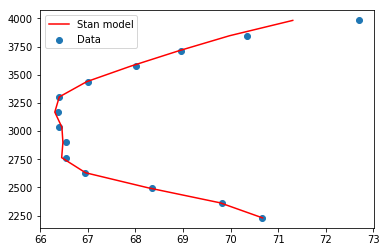

In [98]:
stanfit = model(lmodes[0].n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(), fit['A'].mean(), fit['w'].mean(), fit['tau'].mean(), fit['phi'].mean())

plt.subplots()
plt.scatter(f_mod[0], lmodes[0].nu, label = 'Data')
plt.plot(stanfit % dnu_avg[0], stanfit, label = 'Stan model', color = 'r')
plt.legend()

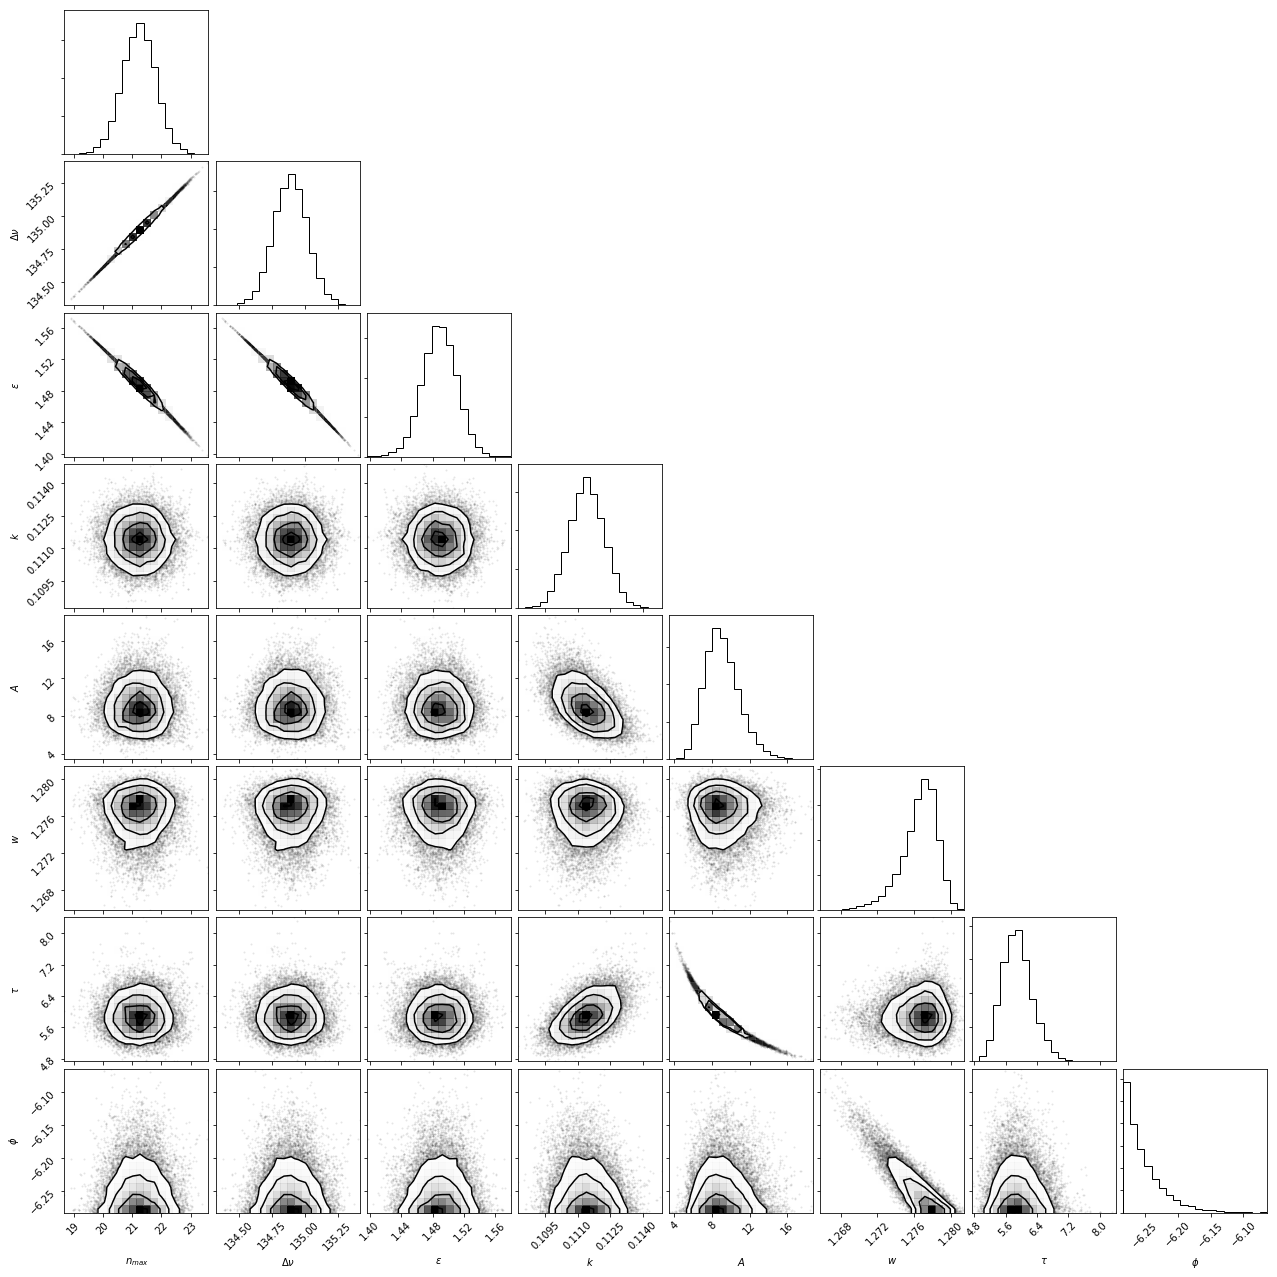

In [99]:
import corner
data = np.vstack([fit['nmax'], fit['dnu'], fit['epsilon'], fit['k'], fit['A'], fit['w'], fit['tau'], fit['phi'],]).T
corner.corner(data, labels=[r'$n_{max}$', r'$\Delta\nu$', r'$\epsilon$', r'$k$', r'$A$', r'$w$', r'$\tau$', r'$\phi$'])
plt.show()